### 라이브러리

In [10]:
from PIL import Image
import cv2
from matplotlib import pyplot as plt

import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

import albumentations
from albumentations.pytorch import ToTensorV2

## TTA(Test Time Augmentation) 

Dataset class -> image loader -> transform

### Basic Dataset

In [2]:
class CatDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        
    def __getitem__(self, index):
        file_path = self.file_paths[index]
        
        #이미지를 PIL을 통하여 읽는다.
        image = Image.open(file_path)
        
        #transform의 시간을 체크한다.
        start_time = time.time()
        if self.transform:
            image = self.transform(image)
        end_time = (time.time() - start_time)
        
        return image, end_time
        
    def __len__(self):
        return len(self.file_paths)

원래라면 __getitem__에서 라벨을 추가한다.

### Basic data aug transforms

In [3]:
torchvision_transform = transforms.Compose([
    
    transforms.Resize((256,256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

__Resize__: 이미지를 256 x 256 크기로 생성한다.  
__RandomCrop__: (width, height)의 잘라낼 크기를 설정하면, 그 크기만큼 랜덤으로 잘라낸다.(center crop은 잘 쓰이지는 않는다.)    
__RandomHorizontalFlip__: 이미지를 좌우 반전을 시켜준다. 좌우가 반전될 확률은 50%로 고정값이다.  
__RandomVerticalFlip__: 위와 동일한 기능으로 상하 반전을 시킨다.  
__ToTensor__: 마지막에 이미지 값을 텐서값으로 해준다.

### 동작

In [4]:
cat_dataset = CatDataset(file_paths = ["./note_image/cat.jpeg"], 
                        transform = torchvision_transform)

In [5]:
total_time = 0
for i in range(100):
    image, end_time = cat_dataset[0]
    total_time += end_time
    
print("torchvision time/image >>" , total_time * 10)

torchvision time/image >> 13.328094482421875


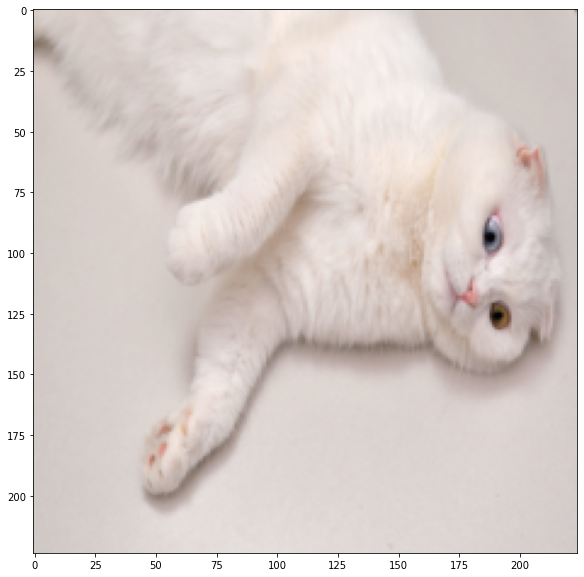

In [6]:
plt.figure(figsize = (10, 10))
plt.imshow(transforms.ToPILImage()(image))
plt.show()

피처와 레이블을 나누어서 transforms를 생성할 경우 Random성이 들어간 것은 레이블에서도 추가할 필요는 없다.

### Albumentations Data pipline

transforms를 직접 만들어서 사용하지 않고 torch 기반에 다양한 augmentation을 지원하는 open source library  
PIL로 못 읽고 cv2로 읽어야한다는 점이 있다.

In [57]:
class alb_cat_dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        
        
    def __getitem__(self, index):
        
        file_path = self.file_paths[index]
        
        #read an image with opencv
        image = cv2.imread(file_path)
        
        # BRG -> RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        start_time = time.time()
        
        if self.transform is not None:
            image = self.transform(image = image)["image"]            #여기가 기존이랑 다르다.
            total_time = (time.time() - start_time)
        
        return image, total_time
        
    def __len__(self):
        return len(self.file_paths)

In [58]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.RandomCrop(224, 224),
    albumentations.VerticalFlip(),
    ToTensorV2()
])

albumentations는 ToTensor할 경우 위에 __from albumentations.pytorch import ToTensorV2__를 가져와야한다.

In [59]:
alb_dataset = alb_cat_dataset(
    file_paths = ['./note_image/cat.jpeg'], transform = albumentations_transform)

In [60]:
alb_total_time = 0
for i in range(100):
    
    alb_image, alb_time = alb_dataset[0]
    alb_total_time += alb_time
    
print("alb >> ", alb_total_time * 10)

alb >>  0.677037239074707


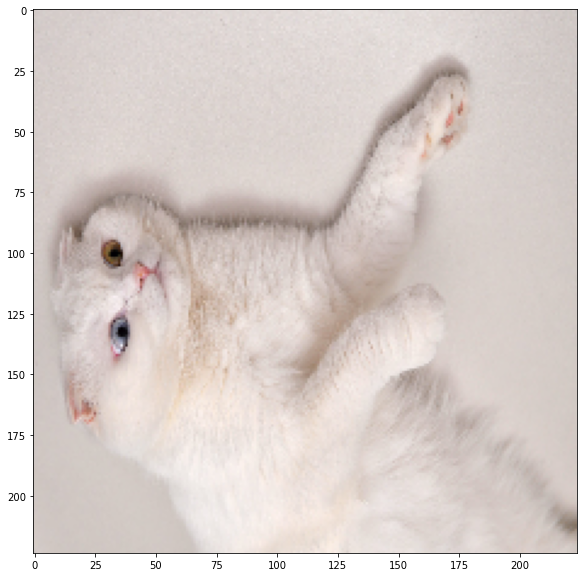

In [67]:
plt.figure(figsize = (10, 10))
plt.imshow(transforms.ToPILImage()(alb_image).convert("RGB"))
plt.show()